In [1]:
import os
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment

def hungarian_match(flat_preds, flat_targets, preds_k, targets_k):
    # Based on implementation from IIC
    num_samples = flat_targets.shape[0]

    assert (preds_k == targets_k)  # one to one
    num_k = preds_k
    num_correct = np.zeros((num_k, num_k))

    for c1 in range(num_k):
        for c2 in range(num_k):
            votes = int(((flat_preds == c1) * (flat_targets == c2)).sum())
            num_correct[c1, c2] = votes

    match = linear_sum_assignment(num_samples - num_correct)
    match = np.array(list(zip(*match)))

    res = {}
    for out_c, gt_c in match:
        res[out_c] = gt_c
        
    return res

model_accuracies = {}
datasets = [('aircraft', 100), ('cub', 200), ('cars', 196), ('dogs', 120), ('flowers', 102), ('nabirds', 555), ('imagenet', 1000)]
split = 'val'
for info in datasets:
    dataset = info[0]
    num_classes = info[1]
    print(f'Dataset: {dataset}')
    
    targets = torch.load(f'/vulcanscratch/mgwillia/vissl/features/swav_r50_800_{dataset}_targets.pth.tar')[f'{split}_targets'].numpy()
    if split == 'train':
        predictions_paths = [path for path in os.listdir('/vulcanscratch/mgwillia/vissl/clusters/') if f'{dataset}_labels.npy' in path]
    elif split == 'val':
        predictions_paths = [path for path in os.listdir('/vulcanscratch/mgwillia/vissl/clusters/') if f'{dataset}_predictions.npy' in path]
        
    print(predictions_paths)
    for predictions_path in predictions_paths:
        predictions = np.load('/vulcanscratch/mgwillia/vissl/clusters/' + predictions_path)

        #TODO: determine labels based on train clusters, not val clusters
        res = hungarian_match(predictions, targets, num_classes, num_classes)
        #print(res)

        remapped_predictions = np.zeros(predictions.shape[0])
        for i in range(predictions.shape[0]):
            remapped_predictions[i] = res[predictions[i]]

        accuracy =  np.where((targets == remapped_predictions), 1, 0).sum() / targets.shape[0]
        model_name = '_'.join(predictions_path.split('_')[:-2])
        if model_name not in model_accuracies:
            model_accuracies[model_name] = []
        model_accuracies[model_name].append(accuracy)
        print(f'Model: {model_name}, Accuracy: {accuracy}')
        
print(model_accuracies)

Dataset: aircraft
['simclr_r50_100_aircraft_predictions.npy', 'swav_r50_800_aircraft_predictions.npy', 'dcv2_r50_800_aircraft_predictions.npy', 'simclr_r50_800_aircraft_predictions.npy', 'simclr_r50_200_aircraft_predictions.npy', 'simclr_r50_1000_aircraft_predictions.npy', 'supervised_r50_aircraft_predictions.npy', 'moco_r50_800_aircraft_predictions.npy', 'simsiam_r50_100_aircraft_predictions.npy', 'btwins_r50_1000_aircraft_predictions.npy', 'simclr_r50_400_aircraft_predictions.npy']
Model: simclr_r50_100, Accuracy: 0.10591059105910591
Model: swav_r50_800, Accuracy: 0.126012601260126
Model: dcv2_r50_800, Accuracy: 0.1392139213921392
Model: simclr_r50_800, Accuracy: 0.1116111611161116
Model: simclr_r50_200, Accuracy: 0.11041104110411042
Model: simclr_r50_1000, Accuracy: 0.10981098109810981
Model: supervised_r50, Accuracy: 0.1569156915691569
Model: moco_r50_800, Accuracy: 0.09840984098409841
Model: simsiam_r50_100, Accuracy: 0.1266126612661266
Model: btwins_r50_1000, Accuracy: 0.13201320

In [5]:
import torch
torch.save(model_accuracies, 'kmeans_results.pth.tar')

In [2]:
results = {}
for model_name, accuracies in model_accuracies.items():
    for i, accuracy in enumerate(accuracies):
        if datasets[i][0] not in results:
            results[datasets[i][0]] = {}
        results[datasets[i][0]][model_name.split('_')[0]] = accuracy * 100

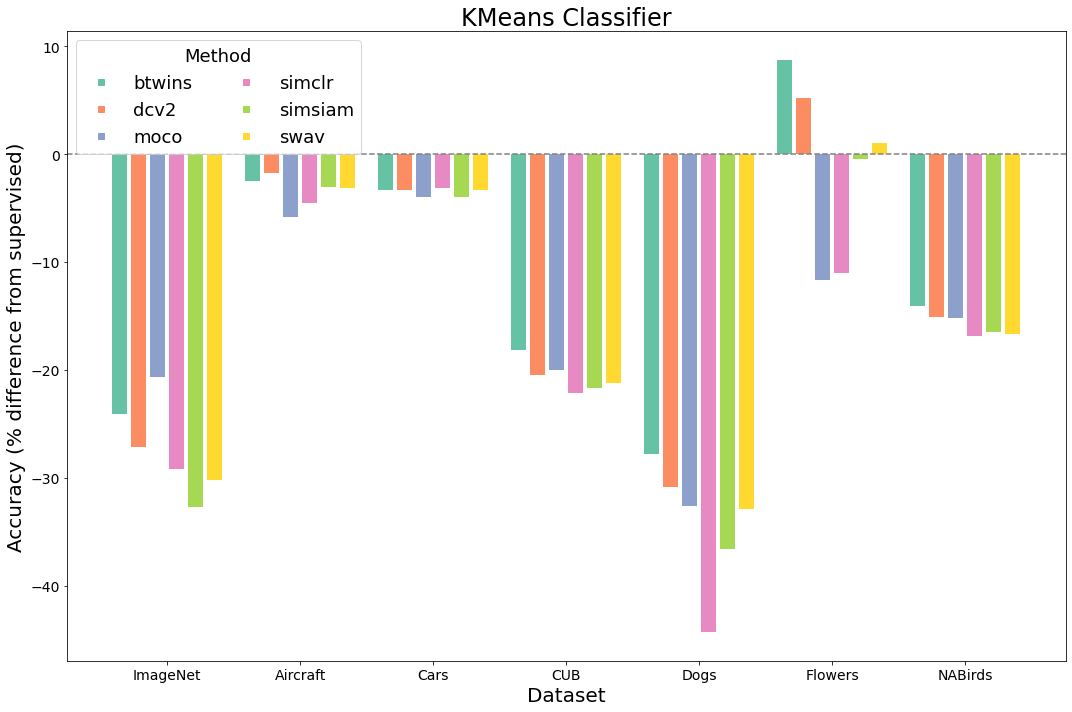

In [4]:
### MAKE BAR PLOT ###
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
cmap = plt.get_cmap('Set2')
colormap = np.array(list(cmap.colors))

datasets = ['ImageNet', 'Aircraft', 'Cars', 'CUB', 'Dogs', 'Flowers', 'NABirds']
method_names = ['btwins', 'dcv2', 'moco', 'simclr', 'simsiam', 'swav']
method_print_name = {
    'btwins': 'BTwins',
    'dcv2': 'DCv2',
    'moco': 'MoCo',
    'simclr': 'SimCLR',
    'simsiam': 'SimSiam',
    'supervised': 'Supervised',
    'swav': 'SwAV',
}

fig, ax = plt.subplots(1, 1)
layer_name = 'res5'
dataset_ids = []
method_ids = []
accuracies = []
for i, dataset_name in enumerate(datasets):
    for j, method_name in enumerate(method_names):
        final_accuracy = results[dataset_name.lower()][method_name]
        dataset_ids.append(i * (len(method_names) + 1) + j + 1)
        method_ids.append(j)
        accuracies.append(final_accuracy - results[dataset_name.lower()]['supervised'])
ax.bar(dataset_ids, accuracies, color=colormap[method_ids])
ax.legend([], [], title=f'Layer: {layer_name}', title_fontsize=16, loc='lower right', frameon=False)
ax.set_xticks(0.5 + np.array(list(range(3, len(datasets) * 7 + 3, 7))))
ax.set_xticklabels(datasets, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.axhline(y=0.0, color='gray', linestyle='--')
    
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colormap[i]) for i in range(7)]
ax.legend(handles,
          method_names,
          title='Method',
          title_fontsize=18,
          scatterpoints=1,
          ncol=2,
          fontsize=18)

plt.title(f'KMeans Classifier', fontsize=24)
ax.set_xlabel('Dataset', fontsize=20)
ax.set_ylabel('Accuracy (% difference from supervised)', fontsize=20)

fig.tight_layout()
plt.savefig(f'kmeans_results', bbox_inches = 'tight',
    pad_inches = 0.1)

In [21]:
### MAKE KMeans TABLE ###

method_table_results = {}
for dataset_name, dataset_results in results.items():
    for method_name, accuracy in dataset_results.items():
        if method_name not in method_table_results:
            method_table_results[method_name] = {}
        method_table_results[method_name][dataset_name] = accuracy

dataset_names = ['ImageNet', 'Aircraft', 'Cars', 'CUB', 'Dogs', 'Flowers', 'NABirds']
method_print_name = {
    'btwins': 'BTwins',
    'dcv2': 'DCv2',
    'moco': 'MoCo',
    'simclr': 'SimCLR',
    'simsiam': 'SimSiam',
    'supervised': 'Supervised',
    'swav': 'SwAV',
}

print('\\begin{tabular}{l l l l l l l l}')
print('\\multirow{2}{*}{Method} & \\multicolumn{7}{c}{Dataset} \\\\ \\cmidrule{2-8}')
print('{} & \\multicolumn{1}{c}{' + '} & \\multicolumn{1}{c}{'.join(datasets) + '} \\\\')
print('\\midrule')
for method_name, method_results in method_table_results.items():
    accs = []
    for dataset_name in dataset_names:
        accs.append(f'{method_results[dataset_name.lower()]:.2f}')
    print(f'\t{method_print_name[method_name.split("_")[0]]} & {" & ".join(accs)} \\\\')
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{l l l l l l l l}
\multirow{2}{*}{Method} & \multicolumn{7}{c}{Dataset} \\ \cmidrule{2-8}
{} & \multicolumn{1}{c}{ImageNet} & \multicolumn{1}{c}{Aircraft} & \multicolumn{1}{c}{Cars} & \multicolumn{1}{c}{CUB} & \multicolumn{1}{c}{Dogs} & \multicolumn{1}{c}{Flowers} & \multicolumn{1}{c}{NABirds} \\
\midrule
	SwAV & 28.69 & 12.60 & 8.66 & 14.05 & 20.79 & 56.04 & 9.26 \\
	DCv2 & 31.79 & 13.92 & 8.66 & 14.81 & 22.84 & 60.20 & 10.86 \\
	SimCLR & 30.14 & 11.22 & 8.71 & 12.89 & 21.22 & 46.85 & 9.15 \\
	Supervised & 58.92 & 15.69 & 11.95 & 35.23 & 53.69 & 54.97 & 25.95 \\
	MoCo & 38.30 & 9.84 & 7.98 & 15.21 & 21.10 & 43.34 & 10.75 \\
	SimSiam & 26.20 & 12.66 & 8.03 & 13.57 & 17.07 & 54.51 & 9.53 \\
	BTwins & 34.88 & 13.20 & 8.63 & 17.07 & 25.94 & 63.70 & 11.87 \\
\bottomrule
\end{tabular}
